<a href="https://www.kaggle.com/code/parisanahmadi/dl-diabet-retinopathy-detection-95-acc-by-parisan?scriptVersionId=102739651" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# ****Deep Computer Vision****

In this guide we will learn how to peform image classification and object detection/recognition using deep computer vision with something called a convolutional neural network.

The goal of our convolutional neural networks will be to classify and detect images or specific objects from within the image. We will be using image data as our features and a label for those images as our label or output.

We already know how neural networks work so we can skip through the basics and move right into explaining the following concepts.

*     Image Data
*     Convolutional Layer
*     Pooling Layer
*     CNN Architectures

The major differences I am about to see in these types of neural networks are the layers that make them up.


# Components of CNN

The CNN model works in two steps: feature extraction and Classification[1]

Feature Extraction is a phase where various filters and layers are applied to the images to extract the information and features out of it and once it’s done it is passed on to the next phase i.e Classification where they are classified based on the target variable of the problem.

A typical CNN model looks like this:

    Input layer
    Convolution layer + Activation function
    Pooling layer
    Fully Connected Layer

![](https://editor.analyticsvidhya.com/uploads/75211cnn-schema1.jpg)


Let’s learn about each layer in detail.

# Input layer

As the name says, it’s our input image and can be Grayscale or RGB. Every image is made up of pixels that range from 0 to 255. We need to normalize them i.e convert the range between 0 to 1  before passing it to the model.

Below is the example of an input image of size 4*4 and has 3 channels i.e RGB and pixel values.


![](https://editor.analyticsvidhya.com/uploads/98920pixel%20image.png)



# Convolution Layer

The convolution layer is the layer where the filter is applied to our input image to extract or detect its features. A filter is applied to the image multiple times and creates a feature map which helps in classifying the input image. Let’s understand this with the help of an example. For simplicity, we will take a 2D input image with normalized pixels.

![](https://editor.analyticsvidhya.com/uploads/57527Screenshot%20(155).png)

In the above figure, we have an input image of size 6*6 and applied a filter of 3*3 on it to detect some features. In this example, we have applied only one filter but in practice, many such filters are applied to extract information from the image.

The result of applying the filter to the image is that we get a Feature Map of 4*4 which has some information about the input image. Many such feature maps are generated in practical applications.

Let’s get into some maths behind getting the feature map in the above image.

![](https://editor.analyticsvidhya.com/uploads/89436Screenshot%20(156).png)



As presented in the above figure, in the first step the filter is applied to the green highlighted part of the image, and the pixel values of the image are multiplied with the values of the filter (as shown in the figure using lines) and then summed up to get the final value.

In the next step, the filter is shifted by one column as shown in the below figure. This jump to the next column or row is known as stride and in this example, we are taking a stride of 1 which means we are shifting by one column.

![](https://editor.analyticsvidhya.com/uploads/47821Screenshot%20(158).png)


Similarly, the filter passes over the entire image and we get our final Feature Map. Once we get the feature map, an activation function is applied to it for introducing nonlinearity.

A point to note here is that the Feature map we get is smaller than the size of our image. As we increase the value of stride the size of the feature map decreases.

![](https://editor.analyticsvidhya.com/uploads/86290Screenshot%20(159).png)

This is how a filter passes through the entire image with the stride of 1

# Pooling Layer

The pooling layer is applied after the Convolutional layer and is used to reduce the dimensions of the feature map which helps in preserving the important information or features of the input image and reduces the computation time.

Using pooling, a lower resolution version of input is created that still contains the large or important elements of the input image.

The most common types of Pooling are Max Pooling and Average Pooling. The below figure shows how Max Pooling works. Using the Feature map which we got from the above example to apply Pooling. Here we are using a Pooling layer of size 2*2 with a stride of 2.

The maximum value from each highlighted area is taken and a new version of the input image is obtained which is of size 2*2 so after applying Pooling the dimension of the feature map has reduced. 

![](https://editor.analyticsvidhya.com/uploads/30447Screenshot%20(160).png)


# Fully Connected Layer

Till now we have performed the Feature Extraction steps, now comes the Classification part. The Fully connected layer (as we have in ANN) is used for classifying the input image into a label. This layer connects the information extracted from the previous steps (i.e Convolution layer and Pooling layers) to the output layer and eventually classifies the input into the desired label.

The complete process of a CNN model can be seen in the below image.

![](https://editor.analyticsvidhya.com/uploads/29624cnn_banner.png)


# **Diabetic Retinopathy Detection**
****Identify signs of diabetic retinopathy in eye images****


Diabetic retinopathy is the leading cause of blindness in the working-age population of the developed world. It is estimated to affect over 93 million people.

![](https://storage.googleapis.com/kaggle-competitions/kaggle/4104/media/retina.jpg)


The US Center for Disease Control and Prevention estimates that 29.1 million people in the US have diabetes and the World Health Organization estimates that 347 million people have the disease worldwide. Diabetic Retinopathy (DR) is an eye disease associated with long-standing diabetes. Around 40% to 45% of Americans with diabetes have some stage of the disease. Progression to vision impairment can be slowed or averted if DR is detected in time, however this can be difficult as the disease often shows few symptoms until it is too late to provide effective treatment.

Currently, detecting DR is a time-consuming and manual process that requires a trained clinician to examine and evaluate digital color fundus photographs of the retina. By the time human readers submit their reviews, often a day or two later, the delayed results lead to lost follow up, miscommunication, and delayed treatment.

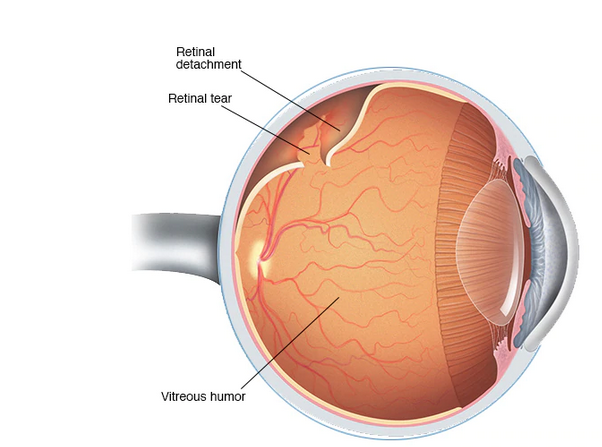

Clinicians can identify DR by the presence of lesions associated with the vascular abnormalities caused by the disease. While this approach is effective, its resource demands are high. The expertise and equipment required are often lacking in areas where the rate of diabetes in local populations is high and DR detection is most needed. As the number of individuals with diabetes continues to grow, the infrastructure needed to prevent blindness due to DR will become even more insufficient.

The need for a comprehensive and automated method of DR screening has long been recognized, and previous efforts have made good progress using image classification, pattern recognition, and machine learning. With color fundus photography as input, the goal of this competition is to push an automated detection system to the limit of what is possible – ideally resulting in models with realistic clinical potential. 

DR: Diabetic Retinopathy

https://www.kaggle.com/competitions/diabetic-retinopathy-detection

# ****About Dataset****
****About the Data****

The images consist of gaussian filtered retina scan images to detect diabetic retinopathy. The original dataset is available at APTOS 2019 Blindness Detection. These images are resized into 224x224 pixels so that they can be readily used with many pre-trained deep learning models.

All of the images are already saved into their respective folders according to the severity/stage of diabetic retinopathy using the train.csv file provided. You will find five directories with the respective images:

****0 - No_DR****

****1 - Mild****

****2 - Moderate****

****3 - Severe****

****4 - Proliferate_DR****



# ****Understanding the Stages of Diabetic Retinopathy****

Elevated blood sugar, blood pressure and cholesterol levels and increased body weight are associated with uncontrolled diabetes and can damage the delicate blood vessels of the retina, causing a disease called diabetic retinopathy. In the early stages of diabetic retinopathy, vision loss may be prevented or limited; but as the condition advances, it becomes more difficult to prevent vision loss.

![](https://www.elmanretina.com/wp-content/uploads/shutterstock_657947524-1024x700.jpg)

****Non-Proliferative Retinopathy****

Non-proliferative diabetic retinopathy is the earlier and less serious stage of the disease. Due to damage from elevated blood sugar levels, the tiny blood vessels of the retina start to swell and leak fluid and blood. The leaking causes swelling inside the retina called macular edema, which is a common cause of visual impairment in people with diabetes.

As non-proliferative retinopathy advances, the blood vessels may become blocked or closed off, and new abnormal blood vessels may start to grow and form in the wrong parts of the retina. Vision is usually unaffected in the non-proliferative stages, but it is best for the retina doctor to watch these changes closely every few months to ensure it doesn’t worsen to the “proliferative” stage.

****Proliferative Diabetic Retinopathy****

The more serious form of the disease, proliferative diabetic retinopathy is characterized by a process known as neovascularization. When the blood vessels of the retina become blocked, the retina is deprived of the oxygen and nutrients it needs to thrive. Sensing its limited blood supply, the retina responds by growing new abnormal blood vessels in the wrong parts of the retina. But the new blood vessels are abnormal and do not provide proper blood flow. They are extremely fragile and, as they grow, can leak blood into the vitreous. Sometimes this bleeding causes visual distortions called floaters; if the bleeding is severe enough, it can partially or completely impair vision.

In some cases, the formation of the new, abnormal blood vessels leads to the development of scar tissue, or fibrosis, in the retina. Scar tissue may cause the retina to wrinkle or “pucker,” or even detach from its normal position along the back of the eye, which is referred to as “tractional retinal detachment.” Depending on the complication, central vision loss can occur.

Another complication to watch out for is the growth of these abnormal blood vessels blocking the drainage angle, the natural mechanism by which fluid exits the eye. If this occurs, pressure inside the eye can spike very quickly, causing neovascular angle-closure glaucoma.


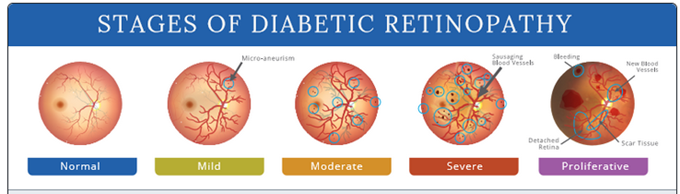

![](https://ai2-s2-public.s3.amazonaws.com/figures/2017-08-08/4e2ccbd15cc04a08c9a096424043c4aee7c4388b/2-Figure1-1.png)

In [1]:
from tensorflow import lite
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import random, os
import shutil
import matplotlib.pyplot as plt
from matplotlib.image import imread
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_accuracy
from sklearn.model_selection import train_test_split

In [2]:
# Add an additional column, mapping to the type
df = pd.read_csv(r'../input/diabetic-retinopathy-224x224-gaussian-filtered/train.csv')

diagnosis_dict_binary = {
    0: 'No_DR',
    1: 'DR',
    2: 'DR',
    3: 'DR',
    4: 'DR'
}

diagnosis_dict = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR',
}


df['binary_type'] =  df['diagnosis'].map(diagnosis_dict_binary.get)
df['type'] = df['diagnosis'].map(diagnosis_dict.get)
df.head()

,id_code,diagnosis,binary_type,type
0,000c1434d8d7,2,DR,Moderate
1,001639a390f0,4,DR,Proliferate_DR
2,0024cdab0c1e,1,DR,Mild
3,002c21358ce6,0,No_DR,No_DR
4,005b95c28852,0,No_DR,No_DR


<AxesSubplot:>

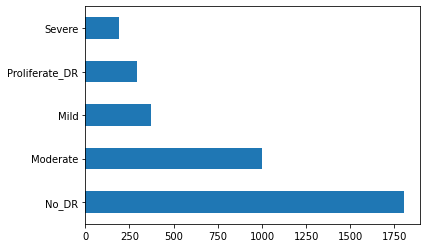

In [3]:
df['type'].value_counts().plot(kind='barh')

<AxesSubplot:>

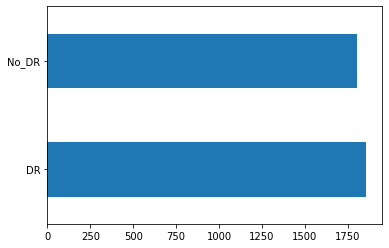

In [4]:
df['binary_type'].value_counts().plot(kind='barh')

In [5]:
# Split into stratified train, val, and test sets
train_intermediate, val = train_test_split(df, test_size = 0.15, stratify = df['type'])
train, test = train_test_split(train_intermediate, test_size = 0.15 / (1 - 0.15), stratify = train_intermediate['type'])

print(train['type'].value_counts(), '\n')
print(test['type'].value_counts(), '\n')
print(val['type'].value_counts(), '\n')


No_DR             1263
Moderate           699
Mild               258
Proliferate_DR     207
Severe             135
Name: type, dtype: int64 

No_DR             271
Moderate          150
Mild               56
Proliferate_DR     44
Severe             29
Name: type, dtype: int64 

No_DR             271
Moderate          150
Mild               56
Proliferate_DR     44
Severe             29
Name: type, dtype: int64 



In [6]:
# Create working directories for train/val/test
base_dir = ''

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
os.makedirs(train_dir)

if os.path.exists(val_dir):
    shutil.rmtree(val_dir)
os.makedirs(val_dir)

if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
os.makedirs(test_dir)


In [7]:
# Copy images to respective working directory
src_dir = r'../input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images'
for index, row in train.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(train_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

for index, row in val.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(val_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)
 
for index, row in test.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(test_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)


In [8]:
# Setting up ImageDataGenerator for train/val/test 

train_path = 'train'
val_path = 'val'
test_path = 'test'

train_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(train_path, target_size=(224,224), shuffle = True)
val_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(val_path, target_size=(224,224), shuffle = True)
test_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(test_path, target_size=(224,224), shuffle = False)


Found 2562 images belonging to 2 classes.
Found 550 images belonging to 2 classes.
Found 550 images belonging to 2 classes.


In [9]:
# Building the model

model = tf.keras.Sequential([
    layers.Conv2D(8, (3,3), padding="valid", input_shape=(224,224,3), activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(16, (3,3), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(32, (4,4), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
 
    layers.Flatten(),
    layers.Dense(32, activation = 'relu'),
    layers.Dropout(0.15),
    layers.Dense(2, activation = 'softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['acc'])

history = model.fit(train_batches,
                    epochs=30,
                    validation_data=val_batches)

2022-08-07 15:12:42.508471: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-07 15:12:42.628729: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-07 15:12:42.629703: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-07 15:12:42.631433: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Epoch 1/30


2022-08-07 15:12:47.219413: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


81/81 [==============================] - 17s 111ms/step - loss: 0.4378 - acc: 0.7986 - val_loss: 0.6501 - val_acc: 0.7400
Epoch 2/30
81/81 [==============================] - 9s 109ms/step - loss: 0.2830 - acc: 0.8981 - val_loss: 0.6054 - val_acc: 0.6564
Epoch 3/30
81/81 [==============================] - 9s 106ms/step - loss: 0.2437 - acc: 0.9102 - val_loss: 0.5192 - val_acc: 0.8800
Epoch 4/30
81/81 [==============================] - 9s 110ms/step - loss: 0.2236 - acc: 0.9192 - val_loss: 0.4070 - val_acc: 0.9164
Epoch 5/30
81/81 [==============================] - 9s 112ms/step - loss: 0.2070 - acc: 0.9262 - val_loss: 0.2939 - val_acc: 0.9182
Epoch 6/30
81/81 [==============================] - 9s 105ms/step - loss: 0.1999 - acc: 0.9309 - val_loss: 0.2253 - val_acc: 0.9218
Epoch 7/30
81/81 [==============================] - 9s 105ms/step - loss: 0.1840 - acc: 0.9340 - val_loss: 0.1728 - val_acc: 0.9418
Epoch 8/30
81/81 [==============================] - 9s 108ms/step - loss: 0.1742 - acc

In [10]:
model.save('64x3-CNN.model')

2022-08-07 15:17:17.852410: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [11]:
loss, acc = model.evaluate_generator(test_batches, verbose=1)
# print("Loss: ", loss)
print("Accuracy: ", acc)


/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


18/18 [==============================] - 1s 79ms/step - loss: 0.1613 - acc: 0.9491
Accuracy:  0.9490908980369568


# ****Diabet Retinopathy Detection Section****

In [12]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt


def predict_class(path):
    img = cv2.imread(path)

    RGBImg = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    RGBImg= cv2.resize(RGBImg,(224,224))
    plt.imshow(RGBImg)
    image = np.array(RGBImg) / 255.0
    new_model = tf.keras.models.load_model("64x3-CNN.model")
    predict=new_model.predict(np.array([image]))
    per=np.argmax(predict,axis=1)
    if per==1:
        print('No DR')
    else:
        print('DR')
    

    

No DR


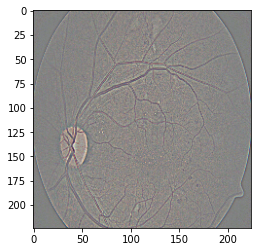

In [13]:
predict_class('../input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images/Proliferate_DR/0243404e8a00.png')


# ****Writer: Parisan Ahmadi****

****Contact: [Medium](http://https://medium.com/@parisan.ahmadi), [Github](http://https://github.com/parisa-ahmadi) , [Parisan's Published Article in LevelUpCoding Journal](http://https://levelup.gitconnected.com/how-to-solve-the-apriori-algorithm-in-a-simple-way-from-scratch-9540cfc5c11a)****





Refrences:
    
[1].https://medium.com/nerd-for-tech/image-classification-using-convolutional-neural-networks-cnn-eef587ed0c1 

[2].https://www.elmanretina.com/understanding-the-stages-of-diabetic-retinopathy/


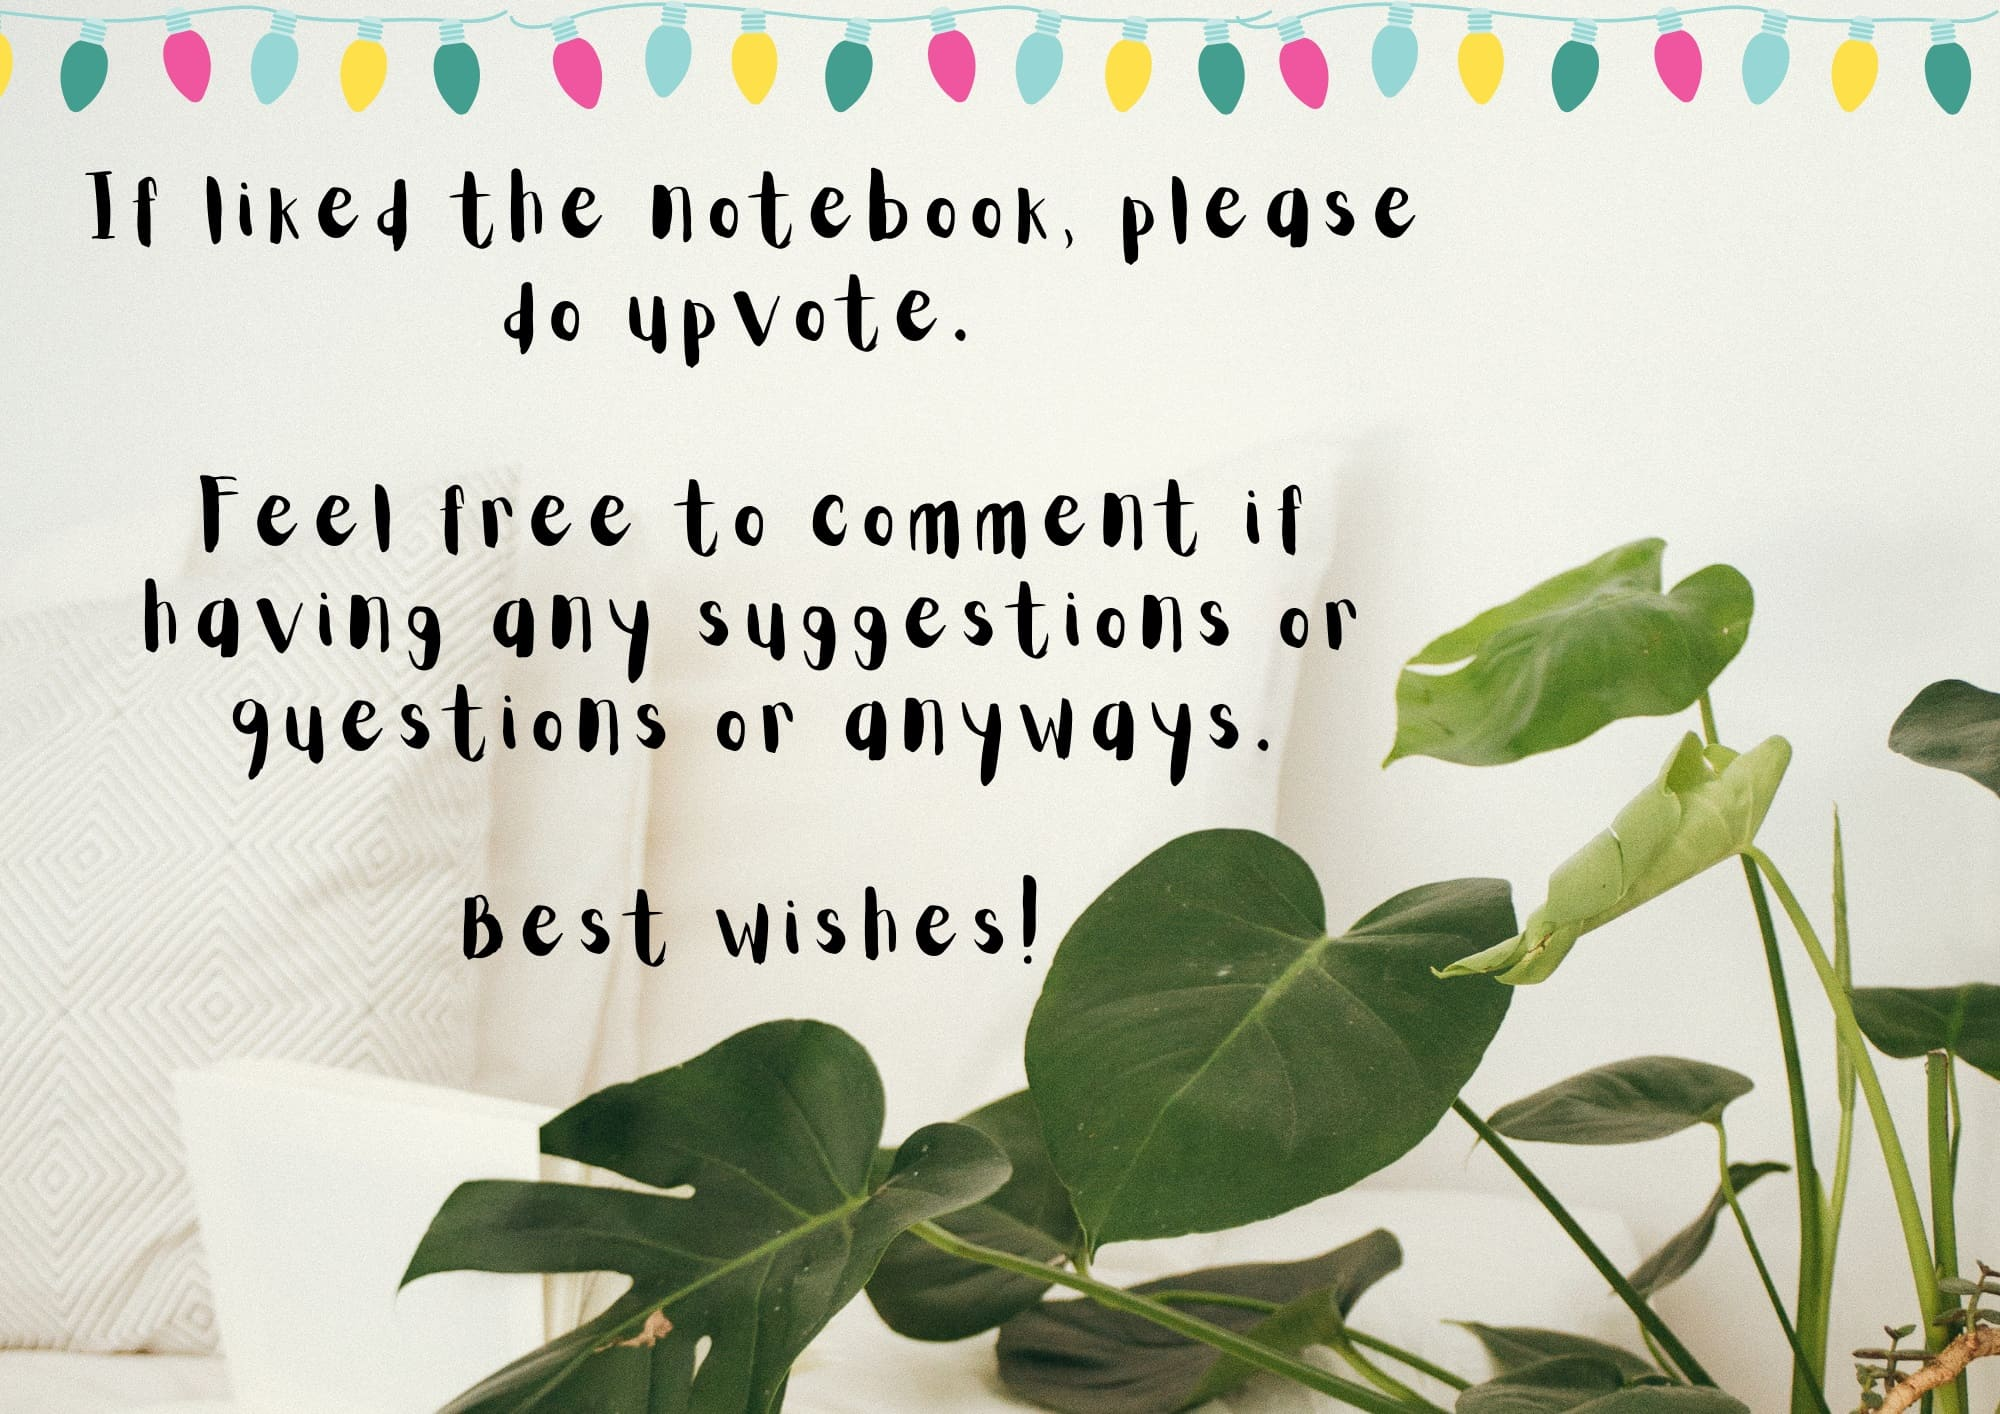